In [3]:
import pandas as pd

wage = pd.read_csv("../../data/Wage.csv")
wage

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [7]:
from ISLP.models import ModelSpec as MS, poly, sklearn_sm
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import numpy as np
from sklearn.model_selection import cross_validate

models = [MS([poly("age", degree=d)]) for d in range(1, 10)]
X, Y = wage[["age"]], wage["wage"]

optimal_degree = None
optimal_err = np.inf

for degree, model in enumerate(models, start=1):  # start=1 so degree matches polynomial
    cross_model = sklearn_sm(sm.OLS, model)
    cv_results = cross_validate(
        cross_model,
        X,
        Y,
        cv=10,
        scoring="neg_mean_squared_error"
    )
    cv_err = -np.mean(cv_results['test_score'])
    if cv_err < optimal_err:
        optimal_err = cv_err
        optimal_degree = degree

optimal_degree, optimal_err

(4, np.float64(1593.9356555746976))

In [ ]:
Xs = [model.fit_transform(wage) for model in models]
anova_lm(*[sm.OLS(Y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.811827,2.128079e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.903818,1.665559e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.815616,5.086990e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.806202,3.693177e-01
5,2993.0,4.766389e+06,1.0,3932.257665,2.471765,1.160134e-01
6,2992.0,4.763834e+06,1.0,2555.281281,1.606216,2.051232e-01
7,2991.0,4.763707e+06,1.0,126.668985,0.079622,7.778293e-01
8,2990.0,4.756703e+06,1.0,7004.317139,4.402820,3.596326e-02


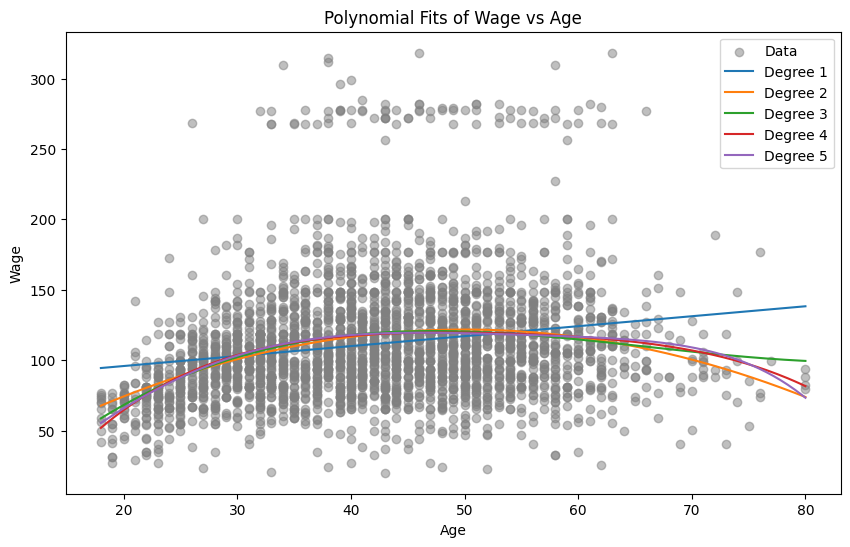

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(X, Y, facecolor="gray", alpha=0.5, label="Data")

age_grid = np.linspace(X["age"].min(), X["age"].max(), 200)
age_df = pd.DataFrame({"age": age_grid})
age_pred = MS(["age"]).fit_transform(wage)

colors = plt.cm.viridis(np.linspace(0,1,len(models)))

for degree in range(1, 6):
    model = MS([poly("age", degree=degree)])
    X_poly = model.fit_transform(wage)
    result = sm.OLS(Y, X_poly).fit()
    
    X_grid = model.transform(age_df)
    y_hat = result.predict(X_grid)
    
    plt.plot(age_grid, y_hat, label=f"Degree {degree}")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("Polynomial Fits of Wage vs Age")
plt.legend()
plt.show()


The result **(4, np.float64(1593.9356555746976))** from the cross-validation indicates that a **4th-degree polynomial** provides the lowest out-of-sample prediction error, with an average mean squared error of about 1594. This suggests that including polynomial terms up to age⁴ yields the best predictive performance on unseen data. Comparing this to the ANOVA table, we can see why the selection makes sense: the first few polynomial terms (age² and age³) provide highly significant improvements, as reflected by the very low p-values and large F-statistics. The 4th-degree term is borderline significant ($p \approx 0.05$), indicating a modest but non-negligible reduction in residual sum of squares. Higher-degree terms beyond the 4th generally have small reductions in SSR and non-significant p-values, meaning they contribute little explanatory power and may lead to overfitting. Together, these results suggest that a 4th-degree polynomial strikes a balance between model complexity and predictive accuracy, capturing most of the curvature in the wage–age relationship without overfitting.


In [ ]:
from ISLP.models import bs

cuts = [MS([bs('age', df=c, degree=0)]) for c in range(1, 50)]

optimal_cuts = None
optimal_err = np.inf

for nb_cuts, model in enumerate(cuts, start=1):
    cross_model = sklearn_sm(sm.OLS, model)
    cv_results = cross_validate(
        cross_model,
        X,
        Y,
        cv=10,
        scoring="neg_mean_squared_error"
    )
    cv_err = -np.mean(cv_results['test_score'])
    if cv_err < optimal_err:
        optimal_err = cv_err
        optimal_cuts = nb_cuts


optimal_cuts, optimal_err

(21, np.float64(1604.4302833803206))

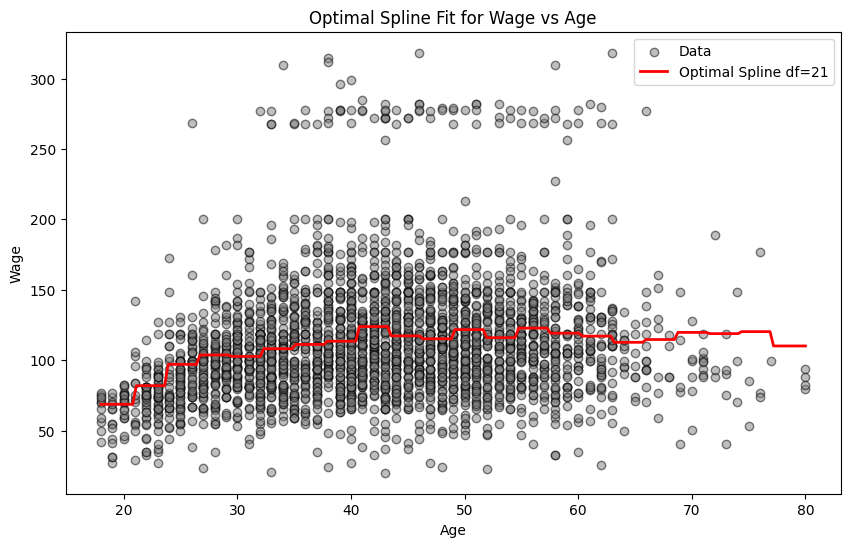

In [ ]:
optimal_model = MS([bs('age', df=optimal_cuts, degree = 0)]).fit_transform(wage)

result = sm.OLS(Y, optimal_model).fit()

plt.figure(figsize=(10,6))
plt.scatter(X["age"], Y, facecolor="gray", edgecolor="k", alpha=0.5, label="Data")

age_grid = np.linspace(X["age"].min(), X["age"].max(), 200)
age_df = pd.DataFrame({"age": age_grid})

X_grid = MS([bs('age', df=optimal_cuts, degree = 0)]).fit_transform(age_df) 
y_hat = result.predict(X_grid)

plt.plot(age_grid, y_hat, color='red', lw=2, label=f"Optimal Spline df={optimal_cuts}")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("Optimal Spline Fit for Wage vs Age")
plt.legend()
plt.show()

The spline captures the general trend of wages increasing with age in early adulthood, leveling off in middle age, and then remaining relatively flat in later years. However, because the spline has many degrees of freedom, it appears somewhat stepwise, reflecting local fluctuations in the data rather than a fully smooth curve. This indicates that while the model fits the data closely, it may be overfitting some of the noise, particularly where the wage distribution is dense. Overall, the spline provides a reasonable summary of the wage-age relationship, showing growth early in the career followed by stabilization.

In [ ]:
Xs = [cut.fit_transform(wage) for cut in cuts[:30]]
anova_lm(*[sm.OLS(Y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.090100e+06,0.0,NaN,NaN,NaN
1,2997.0,4.964933e+06,1.0,125166.598549,78.475182,1.359559e-18
2,2996.0,4.911590e+06,1.0,53342.876110,33.444161,8.090124e-09
3,2995.0,4.904687e+06,1.0,6903.342112,4.328160,3.757157e-02
4,2994.0,4.849668e+06,1.0,55018.566450,34.494762,4.743662e-09
5,2993.0,4.839094e+06,1.0,10574.561216,6.629889,1.007577e-02
6,2992.0,4.814138e+06,1.0,24955.934605,15.646519,7.812463e-05
7,2991.0,4.819862e+06,1.0,-5723.778307,-3.588614,1.000000e+00
8,2990.0,4.815924e+06,1.0,3937.269246,2.468533,1.162521e-01
9,2989.0,4.783941e+06,1.0,31983.627758,20.052642,7.816088e-06


In this case, the ANOVA results are only partially reliable for selecting the optimal model. While they indicate which spline terms for age significantly reduce residual variance on the training data and highlight the main nonlinear patterns, they do not account for overfitting or predictive performance on unseen data. Some later terms appear statistically significant in ANOVA, but cross-validation shows that including them actually worsens generalization, reflecting that ANOVA can overstate the importance of correlated or redundant spline bases. Therefore, although ANOVA provides insight into the contribution of individual terms, it is not fully trustworthy for determining the optimal number of knots, and cross-validation is a more reliable guide in this context.